# 미니 프로젝트 : 가위바위보 분류기를 만들자

**평가문항**
1. 이미지 분류기 모델이 성공적으로 만들어졌는가?
  - 학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
  - 오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
  - 85% 이상 도달하였음

## 0. 라이브러리 호출 및 버전 확인

In [115]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
from sklearn.model_selection import train_test_split

print(tf.__version__)
print(np.__version__)

2.6.0
1.22.2


## 1. 데이터 준비

https://teachablemachine.withgoogle.com/

### 파일 압축풀기

In [82]:
base_path = os.path.expanduser('~/aiffel/15_deep_learning/rock_scissors_paper/')
classes = ['rock', 'scissors', 'paper']

for i in classes:
    img_path = os.path.join(base_path, i)
    zip_file = os.path.join(img_path, f"{i}.zip")
    
    # Check if the zip file exists
    if os.path.exists(zip_file):
        os.chdir(img_path)
        
        # Unzip the file using ! command
        ! unzip -o {zip_file}
        
        print(f"Successfully unzipped {i}.zip to {img_path}")
    else:
        print(f"{zip_file} does not exist.")

Archive:  /aiffel/aiffel/15_deep_learning/rock_scissors_paper/rock/rock.zip
  inflating: rock/0 (2).jpg          
  inflating: rock/0 (3).jpg          
  inflating: rock/0 (4).jpg          
  inflating: rock/0.jpg              
  inflating: rock/1 (2).jpg          
  inflating: rock/1 (3).jpg          
  inflating: rock/1 (4).jpg          
  inflating: rock/1.jpg              
  inflating: rock/10 (2).jpg         
  inflating: rock/10 (3).jpg         
  inflating: rock/10 (4).jpg         
  inflating: rock/10.jpg             
  inflating: rock/100.jpg            
  inflating: rock/101.jpg            
  inflating: rock/102.jpg            
  inflating: rock/103.jpg            
  inflating: rock/104.jpg            
  inflating: rock/105.jpg            
  inflating: rock/106.jpg            
  inflating: rock/107.jpg            
  inflating: rock/108.jpg            
  inflating: rock/109.jpg            
  inflating: rock/11 (2).jpg         
  inflating: rock/11 (3).jpg         
  inflating:

### 이미지 사이즈 변환 

In [83]:
target_size = (28, 28)

def resize_images(i):
    img_path = base_path + f"/{i}/{i}"
    images=glob.glob(img_path + "/*.jpg")  
    print(len(images), "images to be resized.")
    
    for img in images:
        old_image = Image.open(img)
        new_img = old_image.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    print(len(images), "images resized")
    
# Trial 1-3) target_size=(28,28)

In [84]:
for i in classes: 
    resize_images(i)
    print(f"{i} 이미지 resize 완료!")

600 images to be resized.
600 images resized
rock 이미지 resize 완료!
600 images to be resized.
600 images resized
scissors 이미지 resize 완료!
600 images to be resized.
600 images resized
paper 이미지 resize 완료!


### 데이터 불러오기

In [99]:
img_path = base_path + f"paper/paper"
img = glob.glob(img_path + "/*.jpg")
img

['/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/21 (3).jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/44.jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/93 (2).jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/11.jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/235.jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/13 (4).jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/179.jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/116.jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/61 (3).jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/290.jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/159.jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/37 (4).jpg',
 '/aiffel/aiffel/15_deep_learning/rock_scissors_paper/paper/paper/41.jpg',


In [108]:
size_per_class=600
target_img_size=28
target_color=3

def load_data(base_path, number_of_data=size_per_class*len(classes)): 
    
    img_size=target_img_size
    color=target_color
    
    # 이미지 데이터와 라벨 데이터(가위: 0, 바위: 1, 보: 2)를 담을 행렬(matrix) 영역을 생성합니다
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)
    
    idx=0
    
    for i in classes:  
        img_path = base_path + f"{i}/{i}"
        img_list = glob.glob(img_path + "/*.jpg")  
        for img in img_list:
            img = np.array(Image.open(img), dtype=np.int32)
            imgs[idx, :, :, :] = img  # 데이터 영역에 이미지 행렬을 복사

            if i == 'scissors':
                labels[idx] = 0
            elif i == 'rock':
                labels[idx] = 1
            elif i == 'paper':
                labels[idx] = 2

            idx = idx+1
        
    print("이미지 개수는", idx, '입니다.')
    return imgs, labels

(x, y) = load_data(base_path)
print('x shape: {}'.format(x.shape))
print('y shape: {}'.format(y.shape))

# Trial 1-2) 
# img_size=28
# 학습데이터(x_train)의 이미지 개수는 300 입니다.
# x_train shape: (300, 28, 28, 3)
# y_train shape: (300,)

이미지 개수는 1800 입니다.
x shape: (1800, 28, 28, 3)
y shape: (1800,)


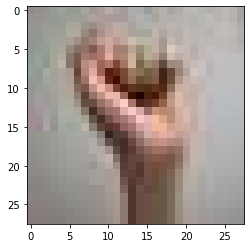

In [109]:
plt.imshow(x[0])

### 입력값 정규화

In [110]:
# 입력을 0-1 사이의 값으로 정규화
x_norm = x/255.0

### train-test split

In [127]:
x_train, x_test, y_train, y_test = train_test_split(
    x_norm, y, random_state=42, stratify=y)

라벨: [[[0.75686275 0.65882353 0.54117647]
  [0.70196078 0.60784314 0.50588235]
  [0.50196078 0.41176471 0.34901961]
  ...
  [0.63921569 0.62352941 0.62745098]
  [0.63921569 0.63137255 0.63529412]
  [0.64705882 0.63921569 0.64313725]]

 [[0.8627451  0.76470588 0.64705882]
  [0.75294118 0.65882353 0.55686275]
  [0.50588235 0.41568627 0.34509804]
  ...
  [0.58823529 0.58039216 0.58431373]
  [0.6        0.59215686 0.59607843]
  [0.61568627 0.60784314 0.61176471]]

 [[0.92156863 0.82352941 0.70196078]
  [0.77647059 0.6745098  0.57647059]
  [0.53333333 0.44313725 0.37254902]
  ...
  [0.30980392 0.30196078 0.31372549]
  [0.32156863 0.31372549 0.3254902 ]
  [0.3372549  0.32941176 0.34117647]]

 ...

 [[0.58039216 0.51372549 0.48627451]
  [0.61568627 0.55686275 0.48235294]
  [0.78823529 0.75294118 0.62352941]
  ...
  [0.23529412 0.23137255 0.25098039]
  [0.25490196 0.25098039 0.27058824]
  [0.25882353 0.25490196 0.2745098 ]]

 [[0.56862745 0.50980392 0.49803922]
  [0.62352941 0.57647059 0.513725

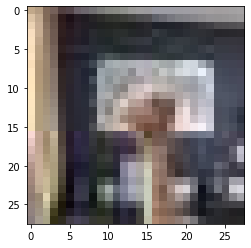

In [128]:
plt.imshow(x_train[0], cmap=plt.cm.binary)
print('라벨:', x_train[0])

## 딥러닝 네트워크 설계하기

In [129]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1=32
n_channel_2=64
n_dense=64

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28, 28, 3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))
model.summary()

# Trial 1-3) 
# n_channel_1=32
# n_channel_2=64
# n_dense=64
# Model에 추가된 Layer 개수:  7
# Model: "sequential_6"
# Model에 추가된 Layer 개수:  7
# Model: "sequential_6"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_12 (Conv2D)           (None, 26, 26, 32)        896       
# _________________________________________________________________
# max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
# _________________________________________________________________
# conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
# _________________________________________________________________
# max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
# _________________________________________________________________
# flatten_6 (Flatten)          (None, 1600)              0         
# _________________________________________________________________
# dense_12 (Dense)             (None, 64)                102464    
# _________________________________________________________________
# dense_13 (Dense)             (None, 3)                 195       
# =================================================================
# Total params: 122,051
# Trainable params: 122,051
# Non-trainable params: 0

Model에 추가된 Layer 개수:  7
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                102464    
_________________________________________________________________
dense_17 (Dense)             (

## 딥러닝 네트워크 학습시키기

In [130]:
n_train_epoch=10

model.compile(optimizer='adam', 
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch, validation_split=0.3)

# Trial 1)
# n_train_epoch=10
# Epoch 1/10
# 10/10 [==============================] - 1s 33ms/step - loss: 0.6202 - accuracy: 0.6133
# Epoch 2/10
# 10/10 [==============================] - 0s 33ms/step - loss: 0.4650 - accuracy: 0.6667
# Epoch 3/10
# 10/10 [==============================] - 0s 33ms/step - loss: 0.4680 - accuracy: 0.6500
# Epoch 4/10
# 10/10 [==============================] - 0s 32ms/step - loss: 0.4646 - accuracy: 0.6700
# Epoch 5/10
# 10/10 [==============================] - 0s 30ms/step - loss: 0.4651 - accuracy: 0.6667
# Epoch 6/10
# 10/10 [==============================] - 0s 33ms/step - loss: 0.4630 - accuracy: 0.6567
# Epoch 7/10
# 10/10 [==============================] - 0s 33ms/step - loss: 0.4644 - accuracy: 0.6667
# Epoch 8/10
# 10/10 [==============================] - 0s 34ms/step - loss: 0.4653 - accuracy: 0.6667
# Epoch 9/10
# 10/10 [==============================] - 0s 33ms/step - loss: 0.4701 - accuracy: 0.6167
# Epoch 10/10
# 10/10 [==============================] - 0s 34ms/step - loss: 0.4628 - accuracy: 0.6700
# <keras.callbacks.History at 0x792b59baca30>

# Trial 2)
# n_train_epoch=10
# Epoch 1/10
# 10/10 [==============================] - 1s 60ms/step - loss: 8.3180 - accuracy: 0.3460 - val_loss: 2.8260 - val_accuracy: 0.3037
# Epoch 2/10
# 10/10 [==============================] - 0s 42ms/step - loss: 1.5075 - accuracy: 0.3905 - val_loss: 1.0462 - val_accuracy: 0.4593
# Epoch 3/10
# 10/10 [==============================] - 0s 42ms/step - loss: 0.9937 - accuracy: 0.4762 - val_loss: 0.9238 - val_accuracy: 0.6000
# Epoch 4/10
# 10/10 [==============================] - 0s 40ms/step - loss: 0.8084 - accuracy: 0.6603 - val_loss: 0.7435 - val_accuracy: 0.7333
# Epoch 5/10
# 10/10 [==============================] - 0s 42ms/step - loss: 0.6962 - accuracy: 0.6889 - val_loss: 0.6332 - val_accuracy: 0.7556
# Epoch 6/10
# 10/10 [==============================] - 0s 42ms/step - loss: 0.5245 - accuracy: 0.8000 - val_loss: 0.5310 - val_accuracy: 0.7630
# Epoch 7/10
# 10/10 [==============================] - 0s 42ms/step - loss: 0.4198 - accuracy: 0.8413 - val_loss: 0.4172 - val_accuracy: 0.8667
# Epoch 8/10
# 10/10 [==============================] - 0s 42ms/step - loss: 0.3531 - accuracy: 0.8476 - val_loss: 0.4023 - val_accuracy: 0.8889
# Epoch 9/10
# 10/10 [==============================] - 0s 43ms/step - loss: 0.2799 - accuracy: 0.9143 - val_loss: 0.3522 - val_accuracy: 0.8519
# Epoch 10/10
# 10/10 [==============================] - 0s 42ms/step - loss: 0.2322 - accuracy: 0.9302 - val_loss: 0.2979 - val_accuracy: 0.9037

# Trial 3)
# n_train_epoch=10
# Epoch 1/10
# 30/30 [==============================] - 2s 44ms/step - loss: 1.0843 - accuracy: 0.4131 - val_loss: 1.0365 - val_accuracy: 0.4975
# Epoch 2/10
# 30/30 [==============================] - 1s 41ms/step - loss: 0.9697 - accuracy: 0.5731 - val_loss: 0.8915 - val_accuracy: 0.5616
# Epoch 3/10
# 30/30 [==============================] - 1s 42ms/step - loss: 0.7974 - accuracy: 0.6748 - val_loss: 0.6671 - val_accuracy: 0.7562
# Epoch 4/10
# 30/30 [==============================] - 1s 42ms/step - loss: 0.5959 - accuracy: 0.7807 - val_loss: 0.5981 - val_accuracy: 0.7291
# Epoch 5/10
# 30/30 [==============================] - 1s 43ms/step - loss: 0.4698 - accuracy: 0.8263 - val_loss: 0.4513 - val_accuracy: 0.8128
# Epoch 6/10
# 30/30 [==============================] - 1s 42ms/step - loss: 0.4004 - accuracy: 0.8538 - val_loss: 0.4108 - val_accuracy: 0.8325
# Epoch 7/10
# 30/30 [==============================] - 1s 42ms/step - loss: 0.3273 - accuracy: 0.8867 - val_loss: 0.3164 - val_accuracy: 0.8842
# Epoch 8/10
# 30/30 [==============================] - 1s 41ms/step - loss: 0.2681 - accuracy: 0.9036 - val_loss: 0.2954 - val_accuracy: 0.8990
# Epoch 9/10
# 30/30 [==============================] - 1s 43ms/step - loss: 0.2485 - accuracy: 0.9269 - val_loss: 0.3146 - val_accuracy: 0.9236
# Epoch 10/10
# 30/30 [==============================] - 1s 41ms/step - loss: 0.1647 - accuracy: 0.9682 - val_loss: 0.1949 - val_accuracy: 0.9680

Epoch 1/10
30/30 [==============================] - 2s 44ms/step - loss: 1.0843 - accuracy: 0.4131 - val_loss: 1.0365 - val_accuracy: 0.4975
Epoch 2/10
30/30 [==============================] - 1s 41ms/step - loss: 0.9697 - accuracy: 0.5731 - val_loss: 0.8915 - val_accuracy: 0.5616
Epoch 3/10
30/30 [==============================] - 1s 42ms/step - loss: 0.7974 - accuracy: 0.6748 - val_loss: 0.6671 - val_accuracy: 0.7562
Epoch 4/10
30/30 [==============================] - 1s 42ms/step - loss: 0.5959 - accuracy: 0.7807 - val_loss: 0.5981 - val_accuracy: 0.7291
Epoch 5/10
30/30 [==============================] - 1s 43ms/step - loss: 0.4698 - accuracy: 0.8263 - val_loss: 0.4513 - val_accuracy: 0.8128
Epoch 6/10
30/30 [==============================] - 1s 42ms/step - loss: 0.4004 - accuracy: 0.8538 - val_loss: 0.4108 - val_accuracy: 0.8325
Epoch 7/10
30/30 [==============================] - 1s 42ms/step - loss: 0.3273 - accuracy: 0.8867 - val_loss: 0.3164 - val_accuracy: 0.8842
Epoch 8/10
30

## 결과 확인

In [131]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

# Trial 1)
# 10/10 - 0s - loss: 0.9713 - accuracy: 1.0000
# test_loss: 0.9712845683097839
# test_accuracy: 1.0

# Trial 2)
# 15/15 - 0s - loss: 0.1992 - accuracy: 0.9556
# test_loss: 0.1992332637310028
# test_accuracy: 0.9555555582046509

# Trial 3)
# 15/15 - 0s - loss: 0.2009 - accuracy: 0.9511
# test_loss: 0.20094792544841766
# test_accuracy: 0.9511111378669739

15/15 - 0s - loss: 0.2009 - accuracy: 0.9511
test_loss: 0.20094792544841766
test_accuracy: 0.9511111378669739


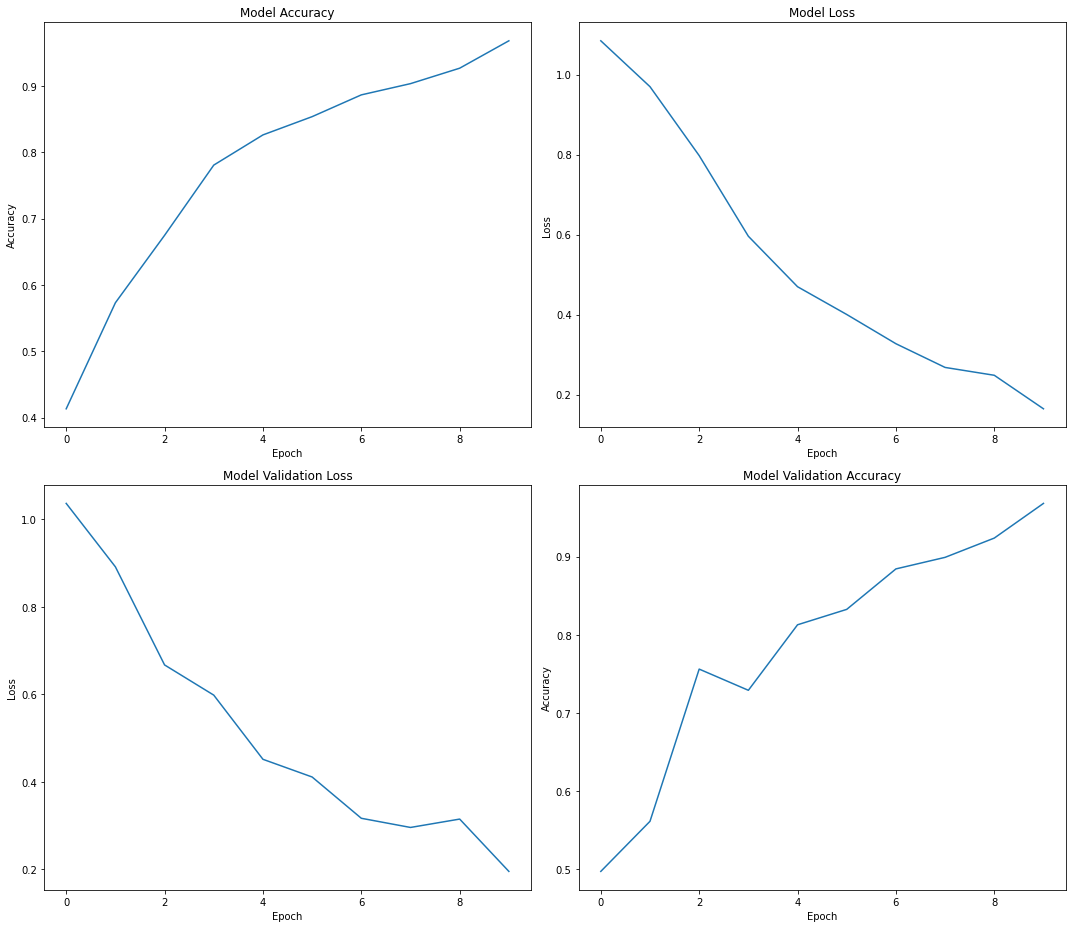

In [132]:
fig, axes = plt.subplots(2, 2, figsize=(15, 13))

# Accuracy
axes[0, 0].plot(history.history['accuracy'])
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xlabel('Epoch')

# Loss
axes[0, 1].plot(history.history['loss'])
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_xlabel('Epoch')

# Validation Loss
axes[1, 0].plot(history.history['val_loss'])
axes[1, 0].set_title('Model Validation Loss')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xlabel('Epoch')

# Validation Accuracy
axes[1, 1].plot(history.history['val_accuracy'])
axes[1, 1].set_title('Model Validation Accuracy')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()